# Information about the notebook
The notebook is splitted into 3 parts: <br>
1: Basics <br>
2: Load & Prepare the Warden data <br>
3: Build the model <br>


# Basics

In [0]:
#Python packages for preparing the data
import os
import shutil as sys
import glob
import sys
import csv

#Python packages for audio files
import wave
import librosa   #for audio processing
import numpy as np
from scipy.io import wavfile #for audio processing
import pandas as pd
import sklearn

Get acces to Google Drive, where the Warden Data is located

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Prepare the Warden Data


Unzip the Warden Data

In [0]:
!unzip -uq '/content/drive/My Drive/speech_commands_v0.02.zip'

Delete the folder:

In [0]:
!rm -rf __MACOSX/

Create a list with all the labels

In [0]:
label_list = os.listdir('/content/speech_commands_v0.02')
print("Original:", label_list)
label_list.remove('_background_noise_')
label_list.remove('.DS_Store')
label_list.remove('README.md')
label_list.remove('testing_list.txt')
label_list.remove('validation_list.txt')
label_list.remove('LICENSE')
print("Removed:",label_list)

Original: ['bed', 'on', 'seven', 'two', 'eight', 'sheila', 'off', 'validation_list.txt', 'README.md', 'wow', 'tree', 'down', 'visual', 'marvin', 'forward', 'zero', 'yes', 'no', '_background_noise_', 'cat', 'six', 'happy', 'up', '.DS_Store', 'learn', 'go', 'bird', 'testing_list.txt', 'dog', 'three', 'right', 'house', 'four', 'one', 'follow', 'stop', 'backward', 'left', 'nine', 'LICENSE', 'five']
Removed: ['bed', 'on', 'seven', 'two', 'eight', 'sheila', 'off', 'wow', 'tree', 'down', 'visual', 'marvin', 'forward', 'zero', 'yes', 'no', 'cat', 'six', 'happy', 'up', 'learn', 'go', 'bird', 'dog', 'three', 'right', 'house', 'four', 'one', 'follow', 'stop', 'backward', 'left', 'nine', 'five']


Load the validation and testing_list (txt format)

In [0]:
validation_list = np.loadtxt('/content/speech_commands_v0.02/validation_list.txt', dtype= str)
testing_list = np.loadtxt('/content/speech_commands_v0.02/testing_list.txt', dtype= str)
print(validation_list)
print(testing_list)

['right/a69b9b3e_nohash_0.wav' 'right/439c84f4_nohash_1.wav'
 'right/409c962a_nohash_1.wav' ... 'four/d3831f6a_nohash_1.wav'
 'four/3c4aa5ef_nohash_3.wav' 'four/c6389ab0_nohash_0.wav']
['right/bb05582b_nohash_3.wav' 'right/97f4c236_nohash_2.wav'
 'right/f2e59fea_nohash_3.wav' ... 'four/c9e251d2_nohash_1.wav'
 'four/0c40e715_nohash_0.wav' 'four/8769c34c_nohash_3.wav']


Convert the wav files into mfcc Data

In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

data_path = '/content/speech_commands_v0.02'
length = 0

#Create 4 empty lists
#Training Data
x_Warden_train = []
y_Warden_train = []
#Validation Data
x_Warden_val = []
y_Warden_val = []
#Test Data
x_Warden_test = []
y_Warden_test = []


for label in label_list:
      print("Label: ", label)
      waves = [f for f in os.listdir(data_path + '/'+ label) if f.endswith('.wav')]
      #Get the number of all files
      length += len(waves)

      for wav in waves:
          #Get sample rate
          with wave.open(data_path + '/' + label + '/' + wav, "rb") as wave_file:
              frame_rate = wave_file.getframerate()

          #Extract samples from the wav file
          samples, sample_rate = librosa.load(data_path + '/' + label + '/' + wav, sr = frame_rate)
          #Resample the samples into 8000 Hz
          samples = librosa.resample(samples, len(samples), 8000)

          #Convert the samples into mfcc data
          mfcc = librosa.feature.mfcc(samples.astype(float),sr=len(samples))
          #Normalize it
          mfcc = sklearn.preprocessing.normalize(mfcc)

          if(mfcc.shape== (20,16)):
          
              length =+ 1
              #Differntiate the data in test, validation and train data 
              if label + '/' + wav in testing_list:
                  x_Warden_test.append(mfcc)
                  y_Warden_test.append(label)
              if label + '/' + wav in validation_list:
                  x_Warden_val.append(mfcc)
                  y_Warden_val.append(label)
              else:
                  x_Warden_train.append(mfcc)
                  y_Warden_train.append(label)
          else:
              print("Wrong Shape:", mfcc.shape," File:", label + "/" + wav)

#Convert Output Labels to int encoded labels
y_Warden_train = le.fit_transform(y_Warden_train)
y_Warden_val = le.fit_transform(y_Warden_val)
y_Warden_test = le.fit_transform(y_Warden_test)

#Note: variables must be int!
from keras.utils import np_utils

y_Warden_train = np_utils.to_categorical(y_Warden_train, num_classes=len(label_list))
y_Warden_val = np_utils.to_categorical(y_Warden_val, num_classes=len(label_list))
y_Warden_test = np_utils.to_categorical(y_Warden_test, num_classes=len(label_list))


#Safe the label_list
my_df = pd.DataFrame(label_list)
my_df.to_csv('/content/drive/My Drive/Warden_data/label_list.csv', index=False, header=False)

#Safe the arrays as npy files
np.save('/content/drive/My Drive/Warden_data/x_Warden_train.npy', x_Warden_train, allow_pickle=True, fix_imports=True)
np.save('/content/drive/My Drive/Warden_data/y_Warden_train.npy', y_Warden_train, allow_pickle=True, fix_imports=True)

np.save('/content/drive/My Drive/Warden_data/x_Warden_val.npy', x_Warden_val, allow_pickle=True, fix_imports=True)
np.save('/content/drive/My Drive/Warden_data/y_Warden_val.npy', y_Warden_val, allow_pickle=True, fix_imports=True)

np.save('/content/drive/My Drive/Warden_data/x_Warden_test.npy', x_Warden_test, allow_pickle=True, fix_imports=True)
np.save('/content/drive/My Drive/Warden_data/y_Warden_test.npy', y_Warden_test, allow_pickle=True, fix_imports=True)

#Safe the arrays as npy files
np.save('/content/drive/My Drive/Warden_data/1x_Warden_train.npy', x_Warden_train, allow_pickle=True, fix_imports=False)
np.save('/content/drive/My Drive/Warden_data/1y_Warden_train.npy', y_Warden_train, allow_pickle=True, fix_imports=False)

np.save('/content/drive/My Drive/Warden_data/1x_Warden_val.npy', x_Warden_val, allow_pickle=True, fix_imports=False)
np.save('/content/drive/My Drive/Warden_data/1y_Warden_val.npy', y_Warden_val, allow_pickle=True, fix_imports=False)

np.save('/content/drive/My Drive/Warden_data/1x_Warden_test.npy', x_Warden_test, allow_pickle=True, fix_imports=False)
np.save('/content/drive/My Drive/Warden_data/1y_Warden_test.npy', y_Warden_test, allow_pickle=True, fix_imports=False)

#Safe the arrays as npy files
np.save('/content/drive/My Drive/Warden_data/2x_Warden_train.npy', x_Warden_train, allow_pickle=False, fix_imports=True)
np.save('/content/drive/My Drive/Warden_data/2y_Warden_train.npy', y_Warden_train, allow_pickle=False, fix_imports=True)

np.save('/content/drive/My Drive/Warden_data/2x_Warden_val.npy', x_Warden_val, allow_pickle=False, fix_imports=True)
np.save('/content/drive/My Drive/Warden_data/2y_Warden_val.npy', y_Warden_val, allow_pickle=False, fix_imports=True)

np.save('/content/drive/My Drive/Warden_data/2x_Warden_test.npy', x_Warden_test, allow_pickle=False, fix_imports=True)
np.save('/content/drive/My Drive/Warden_data/2y_Warden_test.npy', y_Warden_test, allow_pickle=False, fix_imports=True)

#Safe the arrays as npy files
np.save('/content/drive/My Drive/Warden_data/3x_Warden_train.npy', x_Warden_train, allow_pickle=False, fix_imports=False)
np.save('/content/drive/My Drive/Warden_data/2y_Warden_train.npy', y_Warden_train, allow_pickle=False, fix_imports=False)

np.save('/content/drive/My Drive/Warden_data/3x_Warden_val.npy', x_Warden_val, allow_pickle=False, fix_imports=False)
np.save('/content/drive/My Drive/Warden_data/3y_Warden_val.npy', y_Warden_val, allow_pickle=False, fix_imports=False)

numpy.save('/content/drive/My Drive/Warden_data/3x_Warden_test.npy', x_Warden_test, allow_pickle=False, fix_imports=False)
np.save('/content/drive/My Drive/Warden_data/3y_Warden_test.npy', y_Warden_test, allow_pickle=False, fix_imports=False)


Label:  bed
Label:  on
Label:  seven
Label:  two
Label:  eight
Label:  sheila
Label:  off
Label:  wow
Label:  tree
Label:  down
Label:  visual
Label:  marvin
Label:  forward
Label:  zero
Label:  yes
Label:  no
Label:  cat
Label:  six
Label:  happy
Label:  up
Label:  learn
Label:  go
Label:  bird
Label:  dog
Label:  three
Label:  right
Label:  house
Label:  four
Label:  one
Label:  follow
Label:  stop
Label:  backward
Label:  left
Label:  nine
Label:  five


Using TensorFlow backend.


NameError: ignored

Safe the data as npy files

# Build a Model


## Load the as npy files safed data

In [0]:
#Train
x_Warden_train= np.load('/content/drive/My Drive/Warden_data/x_Warden_train.npy', allow_pickle=True, fix_imports=True)
y_Warden_train = np.load('/content/drive/My Drive/Warden_data/y_Warden_train.npy', allow_pickle=True, fix_imports=True)
#Validation Data
x_Warden_val = np.load('/content/drive/My Drive/Warden_data/x_Warden_val.npy', allow_pickle=True, fix_imports=True)
y_Warden_val = np.load('/content/drive/My Drive/Warden_data/y_Warden_val.npy', allow_pickle=True, fix_imports=True)
#Test Data
x_Warden_test = np.load('/content/drive/My Drive/Warden_data/x_Warden_test.npy', allow_pickle=True, fix_imports=True)
y_Warden_test = np.load('/content/drive/My Drive/Warden_data/y_Warden_test.npy', allow_pickle=True, fix_imports=True)

#Load the label_list
with open('/content/drive/My Drive/Warden_data/label_list.csv', 'r') as f:
    reader = csv.reader(f)
    label_list = list(reader)

print(x_Warden_train.shape)
print(x_Warden_val.shape)
print(x_Warden_test.shape)
print(x_Warden_train[1].shape)
print(y_Warden_train[1])

(95848, 20, 16)
(9981, 20, 16)
(11005, 20, 16)
(20, 16)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Shuffle the data

In [0]:
from sklearn.utils import shuffle
x_Warden_train, y_Warden_train = shuffle(x_Warden_train, y_Warden_train, random_state=0)
x_Warden_val, y_Warden_val = shuffle(x_Warden_val, y_Warden_val, random_state=0)
x_Warden_test,y_Warden_test = shuffle(x_Warden_test, y_Warden_test, random_state=0)

## Create the RNN

Choose the batch_size

In [0]:
basis = 95848

for i in range (1,basis):
    batch_size = basis/i
    if batch_size.is_integer():
        print("Model must  work through samples ",batch_size," before updating the parameters with batch_size")

Import packages

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from keras import regularizers
import keras

Define model, use Keras callback and compile model

In [0]:
model = Sequential()

model.add(GRU(1024, input_shape = (20,16),activation='relu', return_sequences= True))
model.add(Dropout(0.1))


model.add(GRU(512,activation='relu', return_sequences= True))
model.add(Dropout(0.1))

model.add(GRU(256, activation='relu', return_sequences= True))
model.add(Dropout(0.1))

model.add(GRU(128, activation='relu', return_sequences= True))
model.add(Dropout(0.1))

model.add(GRU(64, activation='relu',return_sequences= False))
model.add(Dropout(0.1))

model.add(Dense(35, activation='softmax'))
model.summary()

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks_list = [
                    keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        patience=1,
                        mode='min', 
                        verbose=1,
                    )
        ]




Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, 20, 368)           425040    
_________________________________________________________________
dropout_10 (Dropout)         (None, 20, 368)           0         
_________________________________________________________________
gru_11 (GRU)                 (None, 20, 298)           596298    
_________________________________________________________________
dropout_11 (Dropout)         (None, 20, 298)           0         
_________________________________________________________________
gru_12 (GRU)                 (None, 20, 228)           360468    
_________________________________________________________________
dropout_12 (Dropout)         (None, 20, 228)           0         
_________________________________________________________________
gru_13 (GRU)                 (None, 20, 158)          

Train the model

In [0]:
history = model.fit(x_Warden_train,
                    y_Warden_train,
                    batch_size = 600,
                    epochs=15,
                    validation_data = (x_Warden_val, y_Warden_val),
                    callbacks = callbacks_list)

Train on 95848 samples, validate on 9981 samples
Epoch 1/15
95848/95848 [==============================] - 475s 5ms/sample - loss: 3.5095 - acc: 0.0399 - val_loss: 3.4688 - val_acc: 0.0622
Epoch 2/15
95848/95848 [==============================] - 473s 5ms/sample - loss: 3.3236 - acc: 0.0821 - val_loss: 3.1319 - val_acc: 0.1224
Epoch 3/15
95848/95848 [==============================] - 472s 5ms/sample - loss: 3.0189 - acc: 0.1485 - val_loss: 2.7086 - val_acc: 0.2241
Epoch 4/15
95848/95848 [==============================] - 472s 5ms/sample - loss: 2.6206 - acc: 0.2340 - val_loss: 2.3010 - val_acc: 0.3220
Epoch 5/15
95848/95848 [==============================] - 472s 5ms/sample - loss: 2.2257 - acc: 0.3377 - val_loss: 1.8676 - val_acc: 0.4379
Epoch 6/15
95848/95848 [==============================] - 472s 5ms/sample - loss: 1.9542 - acc: 0.4142 - val_loss: 1.6891 - val_acc: 0.4887
Epoch 7/15
95848/95848 [==============================] - 474s 5ms/sample - loss: 1.7636 - acc: 0.4696 - val_lo

KeyboardInterrupt: ignored

Plot the results

In [0]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

In [0]:
#Clear the figure
plt.clf

acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

## Compare different models

In [0]:
#Create 4 empty lists to safe the results of different models
RNN_history_loss = []
RNN_history_val_loss = []
RNN_history_acc = []
RNN_history_val_acc = []

In [0]:
#Use the cell after every development of a model
#Safe the loss in a dic
RNN_history_loss.append(loss)
RNN_history_val_loss.append(val_loss)
#Safe the acc
RNN_history_acc.append(acc)
RNN_history_val_acc.append(val_acc)

#Safe the arrays as npy files
#np.save('/content/drive/My Drive/Warden_data/RNN_history_loss.npy', RNN_history_loss, allow_pickle=True, fix_imports=True)
#np.save('/content/drive/My Drive/Warden_data/RNN_history_val_loss.npy', RNN_history_val_loss, allow_pickle=True, fix_imports=True)

#np.save('/content/drive/My Drive/Warden_data/RNN_history_acc.npy', RNN_history_acc, allow_pickle=True, fix_imports=True)
#np.save('/content/drive/My Drive/Warden_data/RNN_history_val_acc.npy', RNN_history_val_acc, allow_pickle=True, fix_imports=True)

In [0]:
print(RNN_history_val_acc)

Plot the results of all models

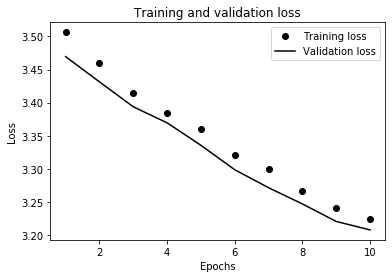

In [0]:
import matplotlib.pyplot as plt

#Create an array with colors
farbe = ['slategrey','mediumblue','red','green','darkorange','cyan','lime','olive','purple','gold']

loss = RNN_history_loss[0]
val_loss = RNN_history_val_loss[0]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss', color = 'black')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color ='black')

for i in range(1,len(RNN_history_loss)):

    loss = RNN_history_loss[i]
    val_loss = RNN_history_val_loss[i]
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', color = farbe[i])
    plt.plot(epochs, val_loss, 'b', color = farbe [i])

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.rcParams['figure.figsize'] = (12,6)
plt.show()

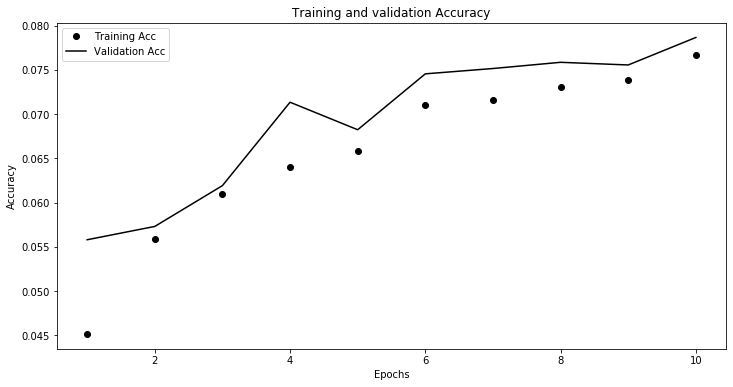

In [0]:
import matplotlib.pyplot as plt

#Create an array with colors
farbe = ['slategrey','mediumblue','red','green','darkorange','cyan','lime','olive','purple','gold']

loss = RNN_history_acc[0]
val_loss = RNN_history_val_acc[0]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training Acc', color = 'black')
plt.plot(epochs, val_loss, 'b', label='Validation Acc', color ='black')

for i in range(1,len(RNN_history_acc)):

    acc = RNN_history_acc[i]
    val_acc = RNN_history_val_acc[i]
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', color = farbe[i])
    plt.plot(epochs, val_acc, 'b', color = farbe [i])

plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.rcParams['figure.figsize'] = (12,6)
plt.show()

## Safe the model


In [0]:
from keras.models import load_model

model.save('test_Warden_model.h5')

In [0]:
from keras.models import load_model
model = load_model('model.h5')